In [1]:
import requests
import seaborn as sns
import pandas as pd
import time
import pickle

In [2]:
urlcook = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cooking&metadata=true&size=500&is_self=true'
urlbegin = 'https://api.pushshift.io/reddit/search/submission?subreddit=cookingforbeginners&metadata=true&size=500&is_self=true'

In [3]:
rescook = requests.get(urlcook)
resbegin = requests.get(urlbegin)

In [4]:
begindict = resbegin.json()
cookdict= rescook.json()

In [5]:
begindict.keys()

dict_keys(['data', 'metadata'])

In [6]:

begindict.get('data')[1].get('created_utc')

1651073092

In [7]:
plotter = [begindict.get('data')[i].get('created_utc') for i in range(len(begindict.get('data')))]

In [8]:
len(plotter)

100

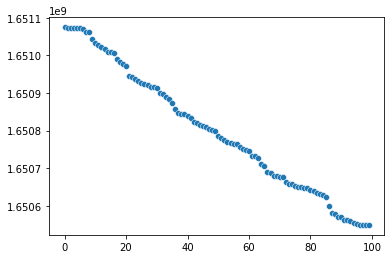

In [9]:
sns.scatterplot(x=list(range(100)),y=plotter);

All of this was just confirmation that the scrape goes back monotonically in time. Of note, while size was set to 500, we only got 100 hits, suggesting we should be careful about how our scraping works and give time to pulls- and it might be the case that their API (https://github.com/pushshift/api) is outdated. Moving forwards, let's see what data keys there are that can be of interest

In [10]:
list(begindict.get('data')[0].keys())

['all_awardings',
 'allow_live_comments',
 'author',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_text',
 'author_flair_type',
 'author_fullname',
 'author_is_blocked',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'created_utc',
 'domain',
 'full_link',
 'gildings',
 'id',
 'is_created_from_ads_ui',
 'is_crosspostable',
 'is_meta',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'is_video',
 'link_flair_background_color',
 'link_flair_richtext',
 'link_flair_template_id',
 'link_flair_text',
 'link_flair_text_color',
 'link_flair_type',
 'locked',
 'media_only',
 'no_follow',
 'num_comments',
 'num_crossposts',
 'over_18',
 'parent_whitelist_status',
 'permalink',
 'pinned',
 'pwls',
 'removed_by_category',
 'retrieved_on',
 'score',
 'selftext',
 'send_replies',
 'spoiler',
 'stickied',
 'subreddit',
 'subreddit_id',
 'subreddit_subscribers',
 'subreddit_type',
 'thumbnail',
 '

We'll be looking at text, primarily, but it seems that other factors could be useful. Although, some are just cheating- ex, since r/cooking is a much more popular subreddit than r/cookingforbeginners, we should expect to see far more awards on average, along with other factors.

In [11]:
begindict.get('data')[0].get('subreddit_subscribers')

527532

In [12]:
begindict.get('data')[99].get('subreddit_subscribers')

518642

Interestingly, they seem to be able to track subreddit subscribers at posting. If nothing else, we can use this information to see how, if at all, the subreddit changed over the years.

In [13]:
begindict.get('data')[0]

{'all_awardings': [],
 'allow_live_comments': False,
 'author': 'Bilbo_bagins_35',
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_mfn63yzf',
 'author_is_blocked': False,
 'author_patreon_flair': False,
 'author_premium': False,
 'awarders': [],
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1651074869,
 'domain': 'self.cookingforbeginners',
 'full_link': 'https://www.reddit.com/r/cookingforbeginners/comments/ud6t7p/student_recipes_you_can_recommend_me/',
 'gildings': {},
 'id': 'ud6t7p',
 'is_created_from_ads_ui': False,
 'is_crosspostable': False,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': False,
 'is_self': True,
 'is_video': False,
 'link_flair_background_color': '#7193ff',
 'link_flair_richtext': [],
 'link_flair_template_id': '8a236e74-32f2-11e9-b9df-0ecae544881c',
 'link_flair_text': 'Question',
 'link_f

Given what we see, for submissions, the only relevant keys are 'created_utc', 'domain', 'selftext', 'subreddit_subscribers', 'title'

We want to be flexible, so let's also look at comments

In [14]:
beginurl = 'https://api.pushshift.io/reddit/search/comment/?subreddit=cookingforbeginners&metadata=true&size=500'

In [15]:
beginres = requests.get(beginurl)
dictbegin = beginres.json()

In [16]:
len(dictbegin.get('data'))

100

In [17]:
dictbegin.get('data')[0]

{'all_awardings': [],
 'archived': False,
 'associated_award': None,
 'author': 'AutoModerator',
 'author_flair_background_color': None,
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_template_id': None,
 'author_flair_text': None,
 'author_flair_text_color': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_6l4z3',
 'author_patreon_flair': False,
 'author_premium': True,
 'body': "Hello! It appears that you are trying to post from an account that does not have enough karma. We ask that you engage first, comment on other posts and gain some karma points then try again soon. If this is a legitimate post, and on topic of food (must be directly related), please [message the mods](http://www.reddit.com/message/compose?to=/r/cookingforbeginners), with a link to your post, NOT THE LINK TO THE IMAGE and we'll reinstate it.\n\nAdditionally, please read the [rules of reddit](http://www.reddit.com/rules/).\n\nIf you're thinking of doing any self-promotion

Looking at this, you can tie comments to a specific post by permalink and removing the final '/' pair. Whether that will be useful is yet to be seen, but let's start with as broad a search as we can. In that case, what we need is 'created_utc','body','permalink'

Given what we know, let's try and make an iterable set of instructions that will collect every submission and comment (with relevant information) from the last 4 years. That should easily pass the minimum number of posts and give us a healthy amount of data to crunch to figure out differences

In [19]:
cforbbaseurl = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cookingforbeginners&metadata=true&size=500'
cookingbaseurl = 'https://api.pushshift.io/reddit/search/submission/?subreddit=cooking&metadata=true&size=500'
present_time = 1651037065 #Tuesday, April 26, 2022 10:24:25 PM GMT -7:00, for the curious

In [20]:
dictbegin.get('data')[0].get('created_utc')

1651074869

In [21]:
cforbbaseurl + '&before=' + str(present_time)

'https://api.pushshift.io/reddit/search/submission/?subreddit=cookingforbeginners&metadata=true&size=500&before=1651037065'

In [36]:
starttime = 1524806665

^4 years ago, more or less. Credit to https://www.epochconverter.com/

In [22]:
present_time

1651037065

In [33]:
newrl = cforbbaseurl + '&before=' + str(present_time) + fields


In [34]:
fields = '&fields=created_utc,domain,selftext,subreddit_subscribers,title'

requests.get(newrl)

<Response [200]>

In [39]:
df_cook = pd.DataFrame(columns=['created_utc','domain','selftext','subreddit_subscribers','title'])
df_cforb = pd.DataFrame(columns=['created_utc','domain','selftext','subreddit_subscribers','title'])
fields = '&fields=created_utc,domain,selftext,subreddit_subscribers,title'
#all of these lists should be combined together and dealt with together, but as long as they're pulling from the same places,
#in the same order, it's not too bad to keep them separate just to keep them legible before tossing into a DF
while present_time > starttime:
    time.sleep(2) #to avoid any API overload issues- max calls should be 60/min or 1/sec. 2 calls bc 2 subreddits, so 2 sec sleep
    cnewrl = cookingbaseurl + '&before=' + str(present_time) + fields
    bnewrl = cforbbaseurl + '&before=' + str(present_time) + fields
    subcforb = requests.get(bnewrl)
    subcook = requests.get(cnewrl)
    subcookdata = subcook.json().get('data')
    subcforbdata = subcforb.json().get('data')
    df_cook = pd.concat([df_cook,
                        pd.DataFrame([[
                            subcookdata[i].get('created_utc'),
                            subcookdata[i].get('domain'),
                            subcookdata[i].get('selftext'),
                            subcookdata[i].get('subreddit_subscribers'),
                            subcookdata[i].get('title')]
                        for i in range(len(subcookdata))],
                            columns = ['created_utc','domain','selftext','subreddit_subscribers','title'])])
    df_cforb = pd.concat([df_cforb,
                        pd.DataFrame([[
                            subcforbdata[i].get('created_utc'),
                            subcforbdata[i].get('domain'),
                            subcforbdata[i].get('selftext'),
                            subcforbdata[i].get('subreddit_subscribers'),
                            subcforbdata[i].get('title')]
                        for i in range(len(subcforbdata))],
                            columns = ['created_utc','domain','selftext','subreddit_subscribers','title'])])
    
 
    
    
    present_time = df_cforb.loc[:,'created_utc'].iloc[-1]
    
    
    

In [42]:
df_cforb.shape,df_cook.shape

((21686, 5), (21664, 5))

Note that since present_time was set by the cooking for beginner's time, a much smaller sub overall, the shapes are around the same. For that reason, however, we know that we don't have overlaps, either. Let's preserve this data so we don't have to do this again and again- pickling!

In [45]:
df_cforb.nunique(), df_cook.nunique()

(created_utc              21682
 domain                     371
 selftext                 13347
 subreddit_subscribers    19822
 title                    21265
 dtype: int64,
 created_utc              21634
 domain                      70
 selftext                 16621
 subreddit_subscribers    19757
 title                    21436
 dtype: int64)

Self-Text being less unique overall can be probably because many of the posts are blank or otherwise simple, perhaps even posts sent in error or by mistake

In [8]:
with open('../data/pickledcooking.pkl','wb') as pickle_out:
    pickle.dump(df_cook,pickle_out)

In [9]:
with open('../data/pickledbeginners.pkl','wb') as pickle_out:
    pickle.dump(df_cforb,pickle_out)

Moving on to comments!

In [10]:
bcommurl = 'https://api.pushshift.io/reddit/search/comment/?subreddit=cookingforbeginners&metadata=true&size=500'
ccommurl = 'https://api.pushshift.io/reddit/search/comment/?subreddit=cooking&metadata=true&size=500'

In [16]:
present_time = 1651037065
starttime = 1524806665
commfields = '&fields=created_utc,body,permalink'

In [17]:
df_comm_cook = pd.DataFrame(columns=['created_utc','body','permalink'])
df_comm_cforb = pd.DataFrame(columns=['created_utc','body','permalink'])

while present_time > starttime:
    time.sleep(2)
    ccnewrl = ccommurl + '&before=' +str(present_time) + commfields
    bcnewrl = bcommurl + '&before=' +str(present_time) + commfields
    commcforb = requests.get(bcnewrl)
    commcook = requests.get(ccnewrl)
    commcookdata = commcook.json().get('data')
    commcforbdata = commcforb.json().get('data')
    df_comm_cook = pd.concat([df_comm_cook,
                              pd.DataFrame([[
                                  commcookdata[i].get('created_utc'),
                                  commcookdata[i].get('body'),
                                  commcookdata[i].get('permalink')
                              ] for i in range(len(commcookdata))],
                              columns=['created_utc','body','permalink'])
                             ])
    df_comm_cforb = pd.concat([df_comm_cforb,
                              pd.DataFrame([[
                                  commcforbdata[i].get('created_utc'),
                                  commcforbdata[i].get('body'),
                                  commcforbdata[i].get('permalink')
                              ] for i in range(len(commcforbdata))],
                              columns=['created_utc','body','permalink'])
                             ])
    
    present_time = df_comm_cforb.loc[:,'created_utc'].iloc[-1]
    

KeyboardInterrupt: 

In [13]:
ccommurl + '&before=' +str(present_time) + commfields

'https://api.pushshift.io/reddit/search/comment/?subreddit=cooking&metadata=true&size=500&before=1651037065&fields=created_utc,body,permalink'

In [19]:
df_comm_cook.shape,df_comm_cforb.shape

((100800, 3), (100800, 3))

In [22]:
df_comm_cook.nunique(), df_comm_cforb.nunique()

(created_utc     98573
 body            96953
 permalink      100800
 dtype: int64,
 created_utc    100608
 body            95496
 permalink      100800
 dtype: int64)

In [23]:
df_comm_cforb.loc[:,'created_utc'].iloc[-1]

1606548748

I manually stopped the code, as it had mbeen running for over an hour. Based on the nuniques, it seems that *every single one of those  ** 1008000 ** comments* was unique, and indeed, not some mistake in the programming. I'm not quite sure *if* we'll use comments or how they'll come into play- but our current present time winds up somewhere on Nov 2020- that is, only 1.5 years back, not even half way. Given those constraints, it seems reasonable to stop it. Given that we still know the earliest present_time, it would be trivial to restart the process if needed, but again, with 100800 results, any kind of model fitting would be better fit with something with higher compute than a mid-end laptop from a couple years back and 12 GB of RAM. Again, *if* needed, it would be best done using Google CoLab or some other such source

Then, let's pickle this, and then move to a different worksheet

In [24]:
with open('../data/commpicklecooking.pkl','wb') as pickle_out:
    pickle.dump(df_comm_cook,pickle_out)

In [25]:
with open('../data/commpicklebeginner.pkl','wb') as pickle_out:
    pickle.dump(df_comm_cforb,pickle_out)

One final point to be made- note that in this dataset, the *only* piece of data that was 100% unique was the permalink. While I was worried that in the previous dataset that created_utc was not perfectly unique or title, for that matter, it seems that this is not that surprising- as posts and comments can be sent at the same UTC time or be repetitive